In [3]:
import pandas as pd
import numpy as np
import utils as ut

import matplotlib.pyplot as plt
import seaborn as sns


from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski, AllChem, Draw

from numpy.random import seed
from numpy.random import randn
from scipy.stats import mannwhitneyu

from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
#from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_fscore_support
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, IsolationForest, StackingClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.inspection import permutation_importance

from lazypredict.Supervised import LazyClassifier

import pickle

from chembl_webresource_client.new_client import new_client

/home/thiliban/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [ ]:
target = new_client.target
target_query = target.search('15-lipoxygenase')
target_df = pd.DataFrame.from_dict(target_query)

In [ ]:
target_df

In [ ]:
target_df[(target_df['target_type']=='SINGLE PROTEIN') & (target_df['organism']=='Homo sapiens')] 

In [ ]:
target = target_df.target_chembl_id[3]
target

In [ ]:
activity = new_client.activity
res = activity.filter(target_chembl_id=target)

lox = pd.DataFrame.from_dict(res)
lox

In [ ]:
lox.to_csv('lox_bioactivity_data_raw.csv', index=False)

In [ ]:
#Start executing the cells from here if you already collected the records from the chEMBL!

In [4]:
#load the df

lox = pd.read_csv('lox_bioactivity_data_raw.csv')
lox.head()

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,NaN,232660,[],CHEMBL615145,The compound was tested for the in vitro inhib...,B,NaN,NaN,BAO_0000201,BAO_0000357,...,Homo sapiens,Arachidonate 15-lipoxygenase,9606,NaN,NaN,Inhibition,%,UO_0000187,NaN,22.00
1,NaN,243163,[],CHEMBL615145,The compound was tested for the in vitro inhib...,B,NaN,NaN,BAO_0000201,BAO_0000357,...,Homo sapiens,Arachidonate 15-lipoxygenase,9606,NaN,NaN,Inhibition,%,UO_0000187,NaN,50.00
2,NaN,248509,[],CHEMBL872867,The compound was tested for the in vitro inhib...,B,NaN,NaN,BAO_0000201,BAO_0000357,...,Homo sapiens,Arachidonate 15-lipoxygenase,9606,NaN,NaN,Inhibition,%,UO_0000187,NaN,52.00
3,NaN,252702,[],CHEMBL872867,The compound was tested for the in vitro inhib...,B,NaN,NaN,BAO_0000201,BAO_0000357,...,Homo sapiens,Arachidonate 15-lipoxygenase,9606,NaN,NaN,Inhibition,%,UO_0000187,NaN,44.00
4,NaN,255410,[],CHEMBL615145,The compound was tested for the in vitro inhib...,B,NaN,NaN,BAO_0000201,BAO_0000357,...,Homo sapiens,Arachidonate 15-lipoxygenase,9606,NaN,NaN,Inhibition,%,UO_0000187,NaN,34.00


In [5]:
lox['standard_type'].value_counts()

Potency       5440
IC50           633
Activity       464
Inhibition     256
Imax           164
Ki              87
AC50             6
Vmax(app)        4
EC50             4
Km               4
Ratio IC50       3
Kd               3
%max             3
INH              2
Ratio            2
Kic              1
K                1
Ratio Ki         1
Kiuc             1
Name: standard_type, dtype: int64

In [6]:
#limit dataset to those whose 'standard_type' is 'IC50'
lox = lox.loc[lox['standard_type']=='IC50'] #what is standard type! 
lox.head()

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
6,NaN,347101,[],CHEMBL800469,Inhibitory activity against rabbit reticulocyt...,B,NaN,NaN,BAO_0000190,BAO_0000357,...,Homo sapiens,Arachidonate 15-lipoxygenase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,0.40
7,NaN,349716,[],CHEMBL800469,Inhibitory activity against rabbit reticulocyt...,B,NaN,NaN,BAO_0000190,BAO_0000357,...,Homo sapiens,Arachidonate 15-lipoxygenase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,0.40
8,NaN,351222,[],CHEMBL800469,Inhibitory activity against rabbit reticulocyt...,B,NaN,NaN,BAO_0000190,BAO_0000357,...,Homo sapiens,Arachidonate 15-lipoxygenase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,4.90
9,NaN,354099,[],CHEMBL800469,Inhibitory activity against rabbit reticulocyt...,B,NaN,NaN,BAO_0000190,BAO_0000357,...,Homo sapiens,Arachidonate 15-lipoxygenase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,25.00
10,NaN,359860,[],CHEMBL800469,Inhibitory activity against rabbit reticulocyt...,B,NaN,NaN,BAO_0000190,BAO_0000357,...,Homo sapiens,Arachidonate 15-lipoxygenase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,25.00


In [7]:
#look at datatype and null valyes for standards features! 

standards = [ x for x in lox.columns if 'standard' in x]
lox[standards].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 633 entries, 6 to 7072
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   standard_flag         633 non-null    int64  
 1   standard_relation     583 non-null    object 
 2   standard_text_value   0 non-null      float64
 3   standard_type         633 non-null    object 
 4   standard_units        583 non-null    object 
 5   standard_upper_value  0 non-null      float64
 6   standard_value        583 non-null    float64
dtypes: float64(3), int64(1), object(3)
memory usage: 39.6+ KB


In [8]:
#check types of standards units! 
lox['standard_units'].value_counts() #here we see all the records are in nM! no need to conversion! 

nM    583
Name: standard_units, dtype: int64

In [9]:
#of all the features, we need only 3 to start with! 

columns_keep = ['molecule_chembl_id', 'canonical_smiles', 'standard_value']
lox_basic = lox[columns_keep]
lox_basic

,molecule_chembl_id,canonical_smiles,standard_value
6,CHEMBL177598,O=C(Nc1ccc(CCc2ccc(O)c(O)c2)cc1)c1ccc(Cl)cc1O,400.00
7,CHEMBL175216,Cc1ccc(C(=O)Nc2ccc(CCc3ccc(O)c(O)c3)cc2)c(O)c1,400.00
8,CHEMBL52,CC(Cc1ccc(O)c(O)c1)C(C)Cc1ccc(O)c(O)c1,4900.00
9,CHEMBL176728,O=C(Nc1ccc(CCc2ccc(O)c(O)c2)cc1)c1ccc(-c2ccccc...,25000.00
10,CHEMBL172429,COc1cc(CCc2ccc(NC(=O)c3ccc(C)cc3O)cc2)ccc1O,25000.00
...,...,...,...
7061,CHEMBL1520238,Brc1ccc(CSc2nccn2-c2ccccc2)cc1,50000.00
7062,CHEMBL1352020,CCc1ccc(CSc2nccn2-c2ccccc2)cc1,50000.00
7067,CHEMBL4869861,COc1cccc(CNc2ccc(S(=O)(=O)Nc3nc4c(ccc5ccccc54)...,100000.00
7071,CHEMBL5089414,CCCCCCCCOC(=O)NS(=O)(=O)Nc1cc(-c2cc3ccccc3[nH]...,33.00


In [10]:
#check again for nulls! 

lox_basic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 633 entries, 6 to 7072
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   molecule_chembl_id  633 non-null    object 
 1   canonical_smiles    633 non-null    object 
 2   standard_value      583 non-null    float64
dtypes: float64(1), object(2)
memory usage: 19.8+ KB


#we have to classify the lables into active, intermediate, inactive according to! #It shows 4 classes! 
conditions = [(lox_basic['standard_value'] >= 10000),
              (lox_basic['standard_value'] <= 1000),
              (lox_basic['standard_value'] < 10000)]

values = ['inactive','active','intermediate']
lox_basic['target'] = np.select(conditions,values)

In [11]:
def activiy_classifier(sv): #try doing it with only two classes! 
    
    if float(sv) >= 10000:
        return 'inactive'
    elif float(sv) <= 1000:
        return 'active'
    else:
        return 'intermediate'

In [12]:
lox_basic['target'] = lox_basic['standard_value'].apply(activiy_classifier)

In [13]:
lox_basic.head()

,molecule_chembl_id,canonical_smiles,standard_value,target
6,CHEMBL177598,O=C(Nc1ccc(CCc2ccc(O)c(O)c2)cc1)c1ccc(Cl)cc1O,400.00,active
7,CHEMBL175216,Cc1ccc(C(=O)Nc2ccc(CCc3ccc(O)c(O)c3)cc2)c(O)c1,400.00,active
8,CHEMBL52,CC(Cc1ccc(O)c(O)c1)C(C)Cc1ccc(O)c(O)c1,4900.00,intermediate
9,CHEMBL176728,O=C(Nc1ccc(CCc2ccc(O)c(O)c2)cc1)c1ccc(-c2ccccc...,25000.00,inactive
10,CHEMBL172429,COc1cc(CCc2ccc(NC(=O)c3ccc(C)cc3O)cc2)ccc1O,25000.00,inactive


In [14]:
lox_basic.duplicated('molecule_chembl_id').value_counts()

False    508
True     125
dtype: int64

In [15]:
#delete duplicates!
lox_basic = lox_basic.drop_duplicates('molecule_chembl_id')

In [16]:
lox_basic['target'].value_counts()

inactive        255
intermediate    132
active          121
Name: target, dtype: int64

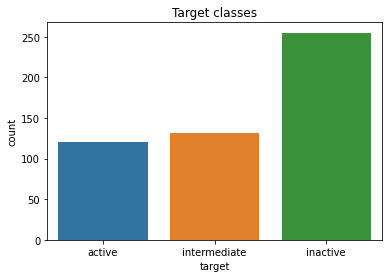

In [17]:
sns.countplot(lox_basic['target'])
plt.title('Target classes')
plt.show()

In [18]:
#save the new dataset! 
lox_basic.to_csv('lox_basic.csv', index=False)

In [19]:
lox_basic = pd.read_csv('lox_basic.csv')

In [20]:
# "." in the smiles record shows a disconnected structure! 

[x for x in lox_basic['canonical_smiles'] if '.' in x]

['C[C@@]12CCC(=O)c3coc(c31)C(=O)c1cc3c(O)ccc(OS(=O)(=O)[O-])c3cc12.[Na+]',
 'CC1=CC[C@H]2C(C)(C)CCC[C@]2(C)[C@H]1C[C@@H](OS(=O)(=O)[O-])[C@H](C)CCC/C(C)=C/Cc1cc(O)ccc1O.[Na+]']

In [21]:
#so we remove the dots from the smiles! 

for i,x in enumerate(lox_basic['canonical_smiles']):
    smiles = x.split('.')
    lox_basic.loc[i, 'canonical_smiles'] = max(smiles, key=len) #How does this line work??
    
lox_basic.head()

,molecule_chembl_id,canonical_smiles,standard_value,target
0,CHEMBL177598,O=C(Nc1ccc(CCc2ccc(O)c(O)c2)cc1)c1ccc(Cl)cc1O,400.00,active
1,CHEMBL175216,Cc1ccc(C(=O)Nc2ccc(CCc3ccc(O)c(O)c3)cc2)c(O)c1,400.00,active
2,CHEMBL52,CC(Cc1ccc(O)c(O)c1)C(C)Cc1ccc(O)c(O)c1,4900.00,intermediate
3,CHEMBL176728,O=C(Nc1ccc(CCc2ccc(O)c(O)c2)cc1)c1ccc(-c2ccccc...,25000.00,inactive
4,CHEMBL172429,COc1cc(CCc2ccc(NC(=O)c3ccc(C)cc3O)cc2)ccc1O,25000.00,inactive


In [22]:
[x for x in lox_basic['canonical_smiles'] if '.' in x] #No we see it is none, smiles has no dots ! 

[]

#Data exploration! 

The Lipinski's Rule stated the following:

    Molecular weight < 500 Dalton
    Octanol-water partition coefficient (LogP) < 5
    Hydrogen bond donors < 5
    Hydrogen bond acceptors < 10


In [23]:
for i, x in enumerate(lox_basic['canonical_smiles']): #i index, x record! 
     
    mol = Chem.MolFromSmiles(x)
    lox_basic.loc[i,'mol_wt'] = Descriptors.MolWt(mol)
    lox_basic.loc[i,'mol_logp'] = Descriptors.MolLogP(mol)
    lox_basic.loc[i,'num_H_don'] = Descriptors.NumHDonors(mol)
    lox_basic.loc[i,'num_H_acpt'] = Descriptors.NumHAcceptors(mol)
    
lox_basic.head()

,molecule_chembl_id,canonical_smiles,standard_value,target,mol_wt,mol_logp,num_H_don,num_H_acpt
0,CHEMBL177598,O=C(Nc1ccc(CCc2ccc(O)c(O)c2)cc1)c1ccc(Cl)cc1O,400.00,active,383.83,4.49,4.00,4.00
1,CHEMBL175216,Cc1ccc(C(=O)Nc2ccc(CCc3ccc(O)c(O)c3)cc2)c(O)c1,400.00,active,363.41,4.15,4.00,4.00
2,CHEMBL52,CC(Cc1ccc(O)c(O)c1)C(C)Cc1ccc(O)c(O)c1,4900.00,intermediate,302.37,3.57,4.00,4.00
3,CHEMBL176728,O=C(Nc1ccc(CCc2ccc(O)c(O)c2)cc1)c1ccc(-c2ccccc...,25000.00,inactive,425.48,5.51,4.00,4.00
4,CHEMBL172429,COc1cc(CCc2ccc(NC(=O)c3ccc(C)cc3O)cc2)ccc1O,25000.00,inactive,377.44,4.45,3.00,4.00


In [24]:
lox_basic.describe()

,standard_value,mol_wt,mol_logp,num_H_don,num_H_acpt
count,475.00,508.00,508.00,508.00,508.00
mean,29379.76,339.16,4.10,1.83,3.66
std,43527.68,108.44,1.56,1.15,1.51
min,1.00,117.15,0.59,0.00,1.00
25%,1000.00,258.11,2.96,1.00,3.00
50%,10000.00,319.66,3.88,2.00,3.00
75%,47650.00,399.83,4.93,2.00,4.00
max,500000.00,1019.13,10.70,8.00,10.00


In [25]:
#save dataset to csv again! 

lox_basic.to_csv('lox_basic_lipinski.csv')

In [26]:
lipinski = pd.read_csv('lox_basic_lipinski.csv')
lipinski.head()

,Unnamed: 0,molecule_chembl_id,canonical_smiles,standard_value,target,mol_wt,mol_logp,num_H_don,num_H_acpt
0,0,CHEMBL177598,O=C(Nc1ccc(CCc2ccc(O)c(O)c2)cc1)c1ccc(Cl)cc1O,400.00,active,383.83,4.49,4.00,4.00
1,1,CHEMBL175216,Cc1ccc(C(=O)Nc2ccc(CCc3ccc(O)c(O)c3)cc2)c(O)c1,400.00,active,363.41,4.15,4.00,4.00
2,2,CHEMBL52,CC(Cc1ccc(O)c(O)c1)C(C)Cc1ccc(O)c(O)c1,4900.00,intermediate,302.37,3.57,4.00,4.00
3,3,CHEMBL176728,O=C(Nc1ccc(CCc2ccc(O)c(O)c2)cc1)c1ccc(-c2ccccc...,25000.00,inactive,425.48,5.51,4.00,4.00
4,4,CHEMBL172429,COc1cc(CCc2ccc(NC(=O)c3ccc(C)cc3O)cc2)ccc1O,25000.00,inactive,377.44,4.45,3.00,4.00


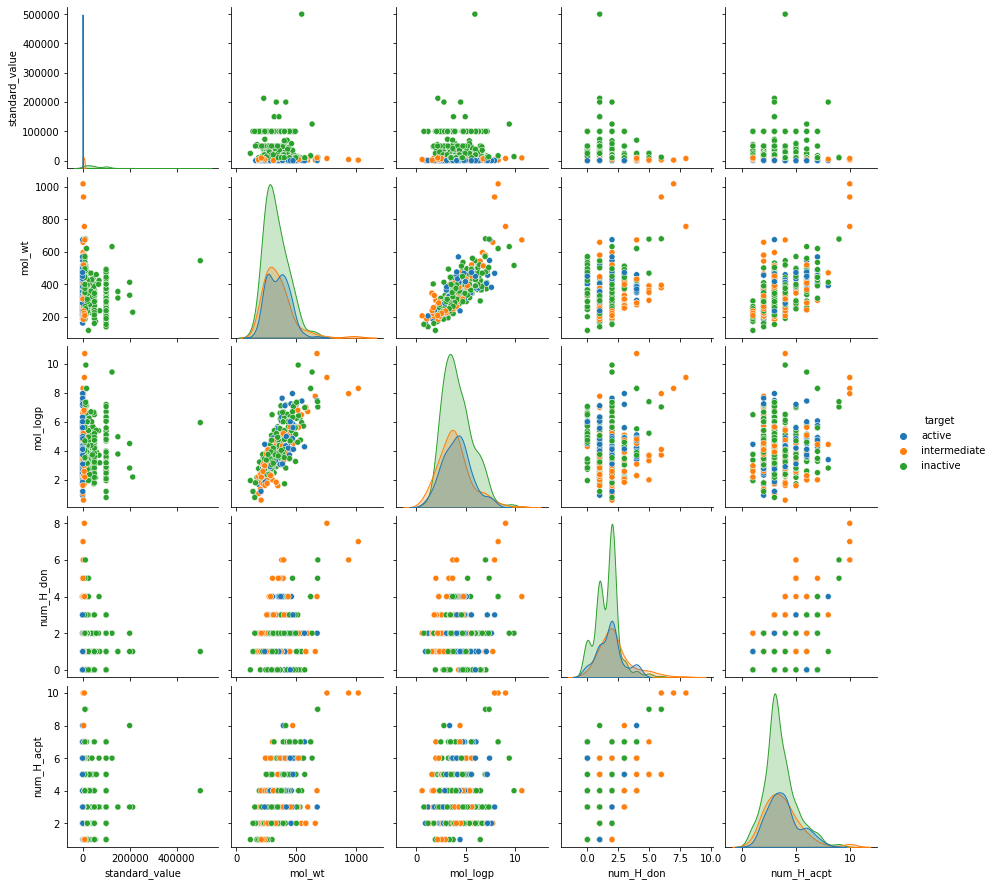

In [27]:
#To find are their any patterns from the dataset! 

sns.pairplot(lox_basic, hue='target')

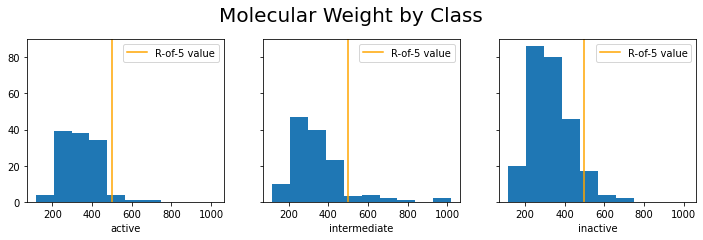

-----------------------------------------------------------------------------------------------




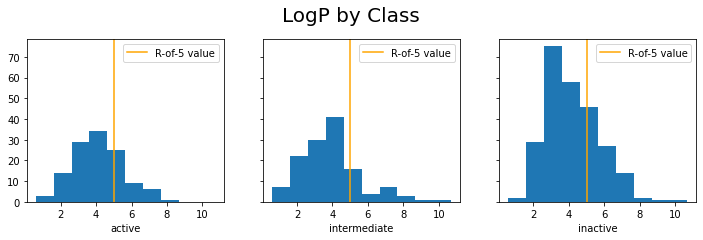

-----------------------------------------------------------------------------------------------




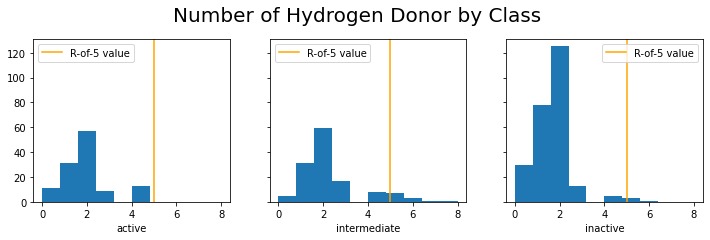

-----------------------------------------------------------------------------------------------




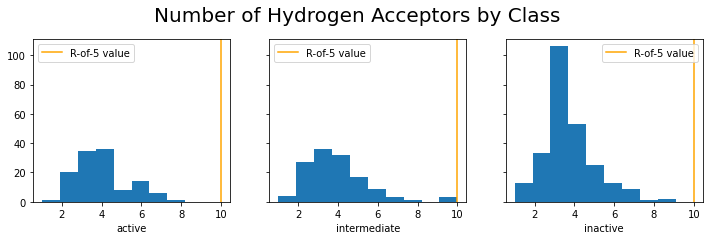

-----------------------------------------------------------------------------------------------




In [29]:


# What is the distribution of the classes for the various features?

# Define features and classes
columns = lox_basic.columns[4:]
classes = ['active', 'intermediate', 'inactive']

# Define the Rule-of-Five criteria
lines = {'mol_wt': 500, 'mol_logp': 5, 'num_H_don': 5, 'num_H_acpt':10}
# Create better titles
titles = {'mol_wt': 'Molecular Weight by Class', 
          'mol_logp': 'LogP by Class', 
          'num_H_don': 'Number of Hydrogen Donor by Class', 
          'num_H_acpt': 'Number of Hydrogen Acceptors by Class'}

# Plot distribution of each feature for each class
for column in columns:
    fig, ax = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
    for i in range(3):
        ax[i].hist(lox_basic[column].loc[lox_basic['target']==classes[i]],
                   range=(lox_basic[column].min(), lox_basic[column].max())) 
        ax[i].set_xlabel(classes[i])
        # Add line to show the Rule-of-Five criteria for each feature
        ax[i].axvline(x=lines.get(column), color='orange', label="R-of-5 value")
        ax[i].legend()
    title = plt.suptitle(titles.get(column), fontsize=20)
    title.set_y(1.03)
    plt.show()
    # Calculate and print Mann Whitney U test statistcs & p-values for
    # each feature for each class pair
    #ut.mannwhitney(lipinski, column)
    # Adding whitespace between feature information
    print('-----------------------------------------------------------------------------------------------')
    print()
    print()



In [30]:
#Download the software padel to collect the features from the chemical compounds! thanks to them! 

! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh


--2023-03-22 09:29:25--  https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip [following]
--2023-03-22 09:29:26--  https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25768637 (25M) [application/zip]
Saving to: ‘padel.zip’

padel.zip           100%[===================>]  24,57M  61,6MB/s    in 0,4s    

2023-03-22 09:29:28 (61,6 MB/s) - ‘padel.zip’ saved [25768637/25768637]

--2023-03-22 09:29:28--  https://githu

In [31]:
! unzip padel.zip

Archive:  padel.zip
   creating: PaDEL-Descriptor/
  inflating: __MACOSX/._PaDEL-Descriptor  
  inflating: PaDEL-Descriptor/MACCSFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._MACCSFingerprinter.xml  
  inflating: PaDEL-Descriptor/AtomPairs2DFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._AtomPairs2DFingerprinter.xml  
  inflating: PaDEL-Descriptor/EStateFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._EStateFingerprinter.xml  
  inflating: PaDEL-Descriptor/Fingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._Fingerprinter.xml  
  inflating: PaDEL-Descriptor/.DS_Store  
  inflating: __MACOSX/PaDEL-Descriptor/._.DS_Store  
   creating: PaDEL-Descriptor/license/
  inflating: __MACOSX/PaDEL-Descriptor/._license  
  inflating: PaDEL-Descriptor/KlekotaRothFingerprintCount.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._KlekotaRothFingerprintCount.xml  
  inflating: PaDEL-Descriptor/config  
  inflating: __MACOSX/PaDEL-Descriptor/._config  
  inf

  inflating: PaDEL-Descriptor/lib/libPaDEL-Descriptor.jar  
  inflating: __MACOSX/PaDEL-Descriptor/lib/._libPaDEL-Descriptor.jar  
  inflating: PaDEL-Descriptor/lib/libPaDEL-Jobs(4).jar  
  inflating: __MACOSX/PaDEL-Descriptor/lib/._libPaDEL-Jobs(4).jar  
  inflating: PaDEL-Descriptor/lib/cdk-1.4.15.jar  
  inflating: __MACOSX/PaDEL-Descriptor/lib/._cdk-1.4.15.jar  
  inflating: PaDEL-Descriptor/lib/ambit2-smarts-2.4.7-SNAPSHOT(5).jar  
  inflating: __MACOSX/PaDEL-Descriptor/lib/._ambit2-smarts-2.4.7-SNAPSHOT(5).jar  
  inflating: PaDEL-Descriptor/lib/ambit2-core-2.4.7-SNAPSHOT(1).jar  
  inflating: __MACOSX/PaDEL-Descriptor/lib/._ambit2-core-2.4.7-SNAPSHOT(1).jar  
  inflating: PaDEL-Descriptor/lib/libPaDEL-Jobs(8).jar  
  inflating: __MACOSX/PaDEL-Descriptor/lib/._libPaDEL-Jobs(8).jar  
  inflating: PaDEL-Descriptor/lib/jgrapht-0.6.0(6).jar  
  inflating: __MACOSX/PaDEL-Descriptor/lib/._jgrapht-0.6.0(6).jar  
  inflating: PaDEL-Descriptor/lib/jama(2).jar  
  inflating: __MACOSX/PaDEL

In [32]:
#prepare the lipinski dataset to fed into the padel program! 
#we need only canonical smiles and chEMBL id to work with here! 

selection = ['canonical_smiles','molecule_chembl_id']
for_modeling = lipinski[selection]

#save the file as the required  .smi file type! 
for_modeling.to_csv('molecules.smi', sep='\t', index=False, header=False)

In [33]:
#view the first 5 rows in the saved dataset! 
! cat molecules.smi | head -5

O=C(Nc1ccc(CCc2ccc(O)c(O)c2)cc1)c1ccc(Cl)cc1O	CHEMBL177598
Cc1ccc(C(=O)Nc2ccc(CCc3ccc(O)c(O)c3)cc2)c(O)c1	CHEMBL175216
CC(Cc1ccc(O)c(O)c1)C(C)Cc1ccc(O)c(O)c1	CHEMBL52
O=C(Nc1ccc(CCc2ccc(O)c(O)c2)cc1)c1ccc(-c2ccccc2)cc1O	CHEMBL176728
COc1cc(CCc2ccc(NC(=O)c3ccc(C)cc3O)cc2)ccc1O	CHEMBL172429


In [34]:
#check the new dataset contains the same number of rows
#Number of rows in the previous dataframe

len(lipinski)

508

In [35]:
! cat molecules.smi | wc -l

508


In [36]:
#Look at file information! 
! cat padel.sh

java -Xms1G -Xmx1G -Djava.awt.headless=true -jar ./PaDEL-Descriptor/PaDEL-Descriptor.jar -removesalt -standardizenitro -fingerprints -descriptortypes ./PaDEL-Descriptor/PubchemFingerprinter.xml -dir ./ -file descriptors_output.csv


In [37]:
! bash padel.sh

Processing CHEMBL177598 in molecules.smi (1/508). 
Processing CHEMBL175315 in molecules.smi (10/508). 
Processing CHEMBL52 in molecules.smi (3/508). 
Processing CHEMBL177171 in molecules.smi (12/508). 
Processing CHEMBL177098 in molecules.smi (7/508). 
Processing CHEMBL367410 in molecules.smi (8/508). 
Processing CHEMBL173802 in molecules.smi (13/508). 
Processing CHEMBL176689 in molecules.smi (11/508). 
Processing CHEMBL172429 in molecules.smi (5/508). 
Processing CHEMBL176923 in molecules.smi (6/508). 
Processing CHEMBL177100 in molecules.smi (9/508). 
Processing CHEMBL175216 in molecules.smi (2/508). 
Processing CHEMBL176728 in molecules.smi (4/508). 
Processing CHEMBL413350 in molecules.smi (15/508). 
Processing CHEMBL177055 in molecules.smi (14/508). 
Processing CHEMBL176634 in molecules.smi (16/508). 
Processing CHEMBL173368 in molecules.smi (17/508). 
Processing CHEMBL92212 in molecules.smi (18/508). 
Processing CHEMBL88952 in molecules.smi (19/508). 
Processing CHEMBL92359 in m

Processing CHEMBL240505 in molecules.smi (119/508). Average speed: 0.05 s/mol.
Processing CHEMBL394459 in molecules.smi (120/508). Average speed: 0.05 s/mol.
Processing CHEMBL210276 in molecules.smi (121/508). Average speed: 0.05 s/mol.
Processing CHEMBL210411 in molecules.smi (122/508). Average speed: 0.05 s/mol.
Processing CHEMBL276915 in molecules.smi (123/508). Average speed: 0.05 s/mol.
Processing CHEMBL138649 in molecules.smi (124/508). Average speed: 0.05 s/mol.
Processing CHEMBL391342 in molecules.smi (125/508). Average speed: 0.05 s/mol.
Processing CHEMBL391341 in molecules.smi (126/508). Average speed: 0.05 s/mol.
Processing CHEMBL238844 in molecules.smi (127/508). Average speed: 0.05 s/mol.
Processing CHEMBL238843 in molecules.smi (128/508). Average speed: 0.05 s/mol.
Processing CHEMBL241815 in molecules.smi (129/508). Average speed: 0.05 s/mol.
Processing CHEMBL241814 in molecules.smi (130/508). Average speed: 0.05 s/mol.
Processing CHEMBL241813 in molecules.smi (131/508). 

Processing CHEMBL3113166 in molecules.smi (225/508). Average speed: 0.04 s/mol.
Processing CHEMBL3113165 in molecules.smi (226/508). Average speed: 0.04 s/mol.
Processing CHEMBL1548353 in molecules.smi (227/508). Average speed: 0.04 s/mol.
Processing CHEMBL3262905 in molecules.smi (228/508). Average speed: 0.04 s/mol.
Processing CHEMBL3262906 in molecules.smi (229/508). Average speed: 0.04 s/mol.
Processing CHEMBL3262907 in molecules.smi (230/508). Average speed: 0.04 s/mol.
Processing CHEMBL3262908 in molecules.smi (231/508). Average speed: 0.04 s/mol.
Processing CHEMBL3262909 in molecules.smi (232/508). Average speed: 0.04 s/mol.
Processing CHEMBL3262910 in molecules.smi (233/508). Average speed: 0.04 s/mol.
Processing CHEMBL3262911 in molecules.smi (234/508). Average speed: 0.04 s/mol.
Processing CHEMBL3262912 in molecules.smi (235/508). Average speed: 0.04 s/mol.
Processing CHEMBL3262913 in molecules.smi (236/508). Average speed: 0.04 s/mol.
Processing CHEMBL3262914 in molecules.sm

Processing CHEMBL3603844 in molecules.smi (328/508). Average speed: 0.03 s/mol.
Processing CHEMBL3604166 in molecules.smi (330/508). Average speed: 0.03 s/mol.
Processing CHEMBL3604165 in molecules.smi (329/508). Average speed: 0.03 s/mol.
Processing CHEMBL3604167 in molecules.smi (331/508). Average speed: 0.03 s/mol.
Processing CHEMBL3604168 in molecules.smi (332/508). Average speed: 0.03 s/mol.
Processing CHEMBL3604169 in molecules.smi (333/508). Average speed: 0.03 s/mol.
Processing CHEMBL3604146 in molecules.smi (334/508). Average speed: 0.03 s/mol.
Processing CHEMBL3604147 in molecules.smi (335/508). Average speed: 0.03 s/mol.
Processing CHEMBL3604148 in molecules.smi (336/508). Average speed: 0.03 s/mol.
Processing CHEMBL3604149 in molecules.smi (337/508). Average speed: 0.03 s/mol.
Processing CHEMBL3604150 in molecules.smi (338/508). Average speed: 0.03 s/mol.
Processing CHEMBL3604170 in molecules.smi (339/508). Average speed: 0.03 s/mol.
Processing CHEMBL3604171 in molecules.sm

Processing CHEMBL4172644 in molecules.smi (431/508). Average speed: 0.03 s/mol.
Processing CHEMBL4172607 in molecules.smi (432/508). Average speed: 0.03 s/mol.
Processing CHEMBL4164711 in molecules.smi (433/508). Average speed: 0.03 s/mol.
Processing CHEMBL4169224 in molecules.smi (434/508). Average speed: 0.03 s/mol.
Processing CHEMBL4161295 in molecules.smi (435/508). Average speed: 0.03 s/mol.
Processing CHEMBL4165793 in molecules.smi (436/508). Average speed: 0.03 s/mol.
Processing CHEMBL4176401 in molecules.smi (437/508). Average speed: 0.03 s/mol.
Processing CHEMBL2141695 in molecules.smi (438/508). Average speed: 0.03 s/mol.
Processing CHEMBL4173018 in molecules.smi (439/508). Average speed: 0.03 s/mol.
Processing CHEMBL4177482 in molecules.smi (440/508). Average speed: 0.03 s/mol.
Processing CHEMBL4169621 in molecules.smi (441/508). Average speed: 0.03 s/mol.
Processing CHEMBL4165794 in molecules.smi (442/508). Average speed: 0.03 s/mol.
Processing CHEMBL4173713 in molecules.sm

In [38]:
#load and view the first 5 rows of the dataset created by padel program! 

df3_X = pd.read_csv('descriptors_output.csv')
df3_X.head()

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,CHEMBL7660,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL316139,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL92359,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL52,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL89283,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
df3_X.describe()

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
count,508.00,508.00,508.00,508.00,508.00,508.00,508.00,508.00,508.00,508.00,...,508.00,508.00,508.00,508.00,508.00,508.00,508.00,508.00,508.00,508.00
mean,0.99,0.88,0.49,0.04,0.00,0.00,0.00,0.00,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
std,0.09,0.32,0.50,0.20,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [ ]:
#chemblID is not needed for model training! We can keep them aside! 

In [42]:
X = df3_X.set_index('Name') #Now the NAME is becoming the index! 
X.head()

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
Name,,,,,,,,,,,,,,,,,,,,,
CHEMBL7660,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
CHEMBL316139,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
CHEMBL92359,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
CHEMBL52,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
CHEMBL89283,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [43]:
#As we see here dataset is ready, X. We need target column, Y.

lipinski = pd.read_csv('lox_basic_lipinski.csv')
y = lipinski['target']

In [44]:
y

0            active
1            active
2      intermediate
3          inactive
4          inactive
           ...     
503        inactive
504        inactive
505        inactive
506        inactive
507          active
Name: target, Length: 508, dtype: object

In [45]:
#We handle binary classification problem! and we dont need intermediate class here! 

y.where(y=='active','inactive',inplace=True)
y.value_counts(normalize=True)

inactive   0.76
active     0.24
Name: target, dtype: float64

In [46]:
y = y.map({'active' : 1, 'inactive' : 0})
y

0      1
1      1
2      0
3      0
4      0
      ..
503    0
504    0
505    0
506    0
507    1
Name: target, Length: 508, dtype: int64

In [57]:
y.value_counts()

0    387
1    121
Name: target, dtype: int64

In [47]:
#split the data into test, train, keeping the index for later use!!
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, X.index, test_size=0.2,
                                                                                random_state=12)

In [49]:
X_train.shape

(406, 881)

In [50]:
#delete the low variance features! 

selection = VarianceThreshold(threshold=(.8 * (1-.8)))

#Fit the training data! 

selection.fit(X_train)


#select only the higher variance features!

X_train = X_train[X_train.columns[selection.get_support(indices=True)]]
X_test = X_test[X_test.columns[selection.get_support(indices=True)]]

In [51]:
X_train.shape #Deleted low variance features and now we have only 170 to train! 



(406, 170)

In [52]:
X_train.to_csv('X_descriptors.csv',index=False)

In [53]:
X_train

,PubchemFP2,PubchemFP12,PubchemFP14,PubchemFP15,PubchemFP19,PubchemFP20,PubchemFP37,PubchemFP143,PubchemFP145,PubchemFP146,...,PubchemFP704,PubchemFP712,PubchemFP714,PubchemFP735,PubchemFP756,PubchemFP761,PubchemFP777,PubchemFP798,PubchemFP819,PubchemFP824
Name,,,,,,,,,,,,,,,,,,,,,
CHEMBL238844,0,1,0,0,1,1,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
CHEMBL1370387,0,1,1,1,1,0,0,1,1,1,...,0,0,0,1,1,0,0,1,1,0
CHEMBL443605,1,0,0,0,1,0,0,0,0,0,...,0,0,1,0,1,0,1,0,1,0
CHEMBL3964779,1,1,1,1,1,0,0,1,0,1,...,1,0,0,0,0,0,0,0,0,0
CHEMBL4521335,1,1,1,1,1,0,1,1,1,1,...,1,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHEMBL1551303,0,0,1,1,0,0,0,1,1,1,...,1,1,0,0,0,0,0,0,0,0
CHEMBL3259851,0,0,1,1,0,0,0,1,1,1,...,1,1,0,0,0,0,0,0,0,0
CHEMBL3980129,1,0,1,1,0,0,1,1,0,1,...,1,0,0,0,0,0,0,0,0,0


In [54]:
#Modeling! 
#Model comparison! and we use lazy predict library to be able to compare the different classifications!

clf = LazyClassifier(verbose=0,ignore_warnings=True,custom_metric=None,random_state=6)
models,predictions = clf.fit(X_train,X_test,y_train,y_test)
models

100%|███████████████████████████████████████████| 29/29 [00:01<00:00, 16.54it/s]

[10:09:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
BernoulliNB,0.62,0.64,0.64,0.63,0.01
NearestCentroid,0.61,0.64,0.64,0.62,0.01
GaussianNB,0.60,0.63,0.63,0.61,0.01
ExtraTreesClassifier,0.69,0.60,0.60,0.66,0.12
LabelSpreading,0.68,0.59,0.59,0.65,0.02
LabelPropagation,0.68,0.59,0.59,0.65,0.03
RandomForestClassifier,0.67,0.59,0.59,0.65,0.15
KNeighborsClassifier,0.68,0.58,0.58,0.64,0.12
ExtraTreeClassifier,0.66,0.58,0.58,0.64,0.01


In [55]:
# Instantiate, fit and evaluate an SVC model
svc = SVC(class_weight='balanced', random_state=6)
svc = svc.fit(X_train, y_train)
ut.evaluate(svc, X_train, X_test, y_train, y_test)

AttributeError: module 'utils' has no attribute 'evaluate'